In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.insert(0, '../../../scripts/dc2')
import verification_utils as utils
%matplotlib inline
%load_ext autoreload
%autoreload 2

Lenstronomy path being used: /home/jwp/stage/sl/lenstronomy/lenstronomy


# Verification of lensed AGN and host in DC2

__Author:__ Ji Won Park (@jiwoncpark)

__Created:__ 5/04/2020

__Last run:__ 5/04/2020

We updated the image positions, magnifications, and time delays originally in the OM10 catalog, so that they agree with the new lens galaxy redshift and DC2 cosmology. In this notebook, we verify whether the code can reproduce the OM10 lensing stats when given the same input as OM10.

In [2]:
utils.to_csv('/home/jwp/stage/sl/LatestSLSprinkler/data/example_truth_050120/updated_lensed_agn_truth.db', '.', '_new')
utils.to_csv('/home/jwp/stage/sl/LatestSLSprinkler/data/example_truth_050120/lensed_agn_truth.db', '.', '')

In [3]:
new_truth = pd.read_csv('lensed_agn_new.csv', index_col=False)
old_truth = pd.read_csv('lensed_agn.csv', index_col=False)

In [4]:
new_truth.shape, old_truth.shape, new_truth.columns

((2446, 39),
 (2446, 39),
 Index(['index', 'unique_id', 'ra', 'dec', 'redshift', 't_delay', 'magnorm',
        'flux_u_agn', 'flux_g_agn', 'flux_r_agn', 'flux_i_agn', 'flux_z_agn',
        'flux_y_agn', 'flux_u_agn_noMW', 'flux_g_agn_noMW', 'flux_r_agn_noMW',
        'flux_i_agn_noMW', 'flux_z_agn_noMW', 'flux_y_agn_noMW',
        'magnification', 'seed', 'agn_tau_u', 'agn_tau_g', 'agn_tau_r',
        'agn_tau_i', 'agn_tau_z', 'agn_tau_y', 'agn_sf_u', 'agn_sf_g',
        'agn_sf_r', 'agn_sf_i', 'agn_sf_z', 'agn_sf_y', 'av_mw', 'rv_mw',
        'lens_id', 'dc2_sys_id', 'lens_cat_sys_id', 'image_number'],
       dtype='object'))

In [5]:
# Basic tests
assert set(new_truth.columns.values) == set(old_truth.columns.values)

In [6]:
new_truth.head()

,index,unique_id,ra,dec,redshift,t_delay,magnorm,flux_u_agn,flux_g_agn,flux_r_agn,...,agn_sf_r,agn_sf_i,agn_sf_z,agn_sf_y,av_mw,rv_mw,lens_id,dc2_sys_id,lens_cat_sys_id,image_number
0,0,GLAGN_0_0,53.494339,-28.283780,1.06,0.000000,23.533316,1.301758e-06,1.434537e-06,0.000002,...,0.6438,0.5863,0.5474,0.5190,0.032723,3.1,2562504569,GLAGN_0,115074,0
1,0,GLAGN_0_1,53.494336,-28.283778,1.06,-2.385178,23.533316,1.301758e-06,1.434537e-06,0.000002,...,0.6438,0.5863,0.5474,0.5190,0.032723,3.1,2562504569,GLAGN_0,115074,1
2,2,GLAGN_1_0,52.567067,-27.584339,2.08,0.000000,23.287786,1.533257e-06,2.309779e-06,0.000003,...,0.3507,0.3189,0.2975,0.2818,0.027206,3.1,1875009351,GLAGN_1,125027,0
3,2,GLAGN_1_1,52.567071,-27.584325,2.08,-28.238358,23.287786,1.533257e-06,2.309779e-06,0.000003,...,0.3507,0.3189,0.2975,0.2818,0.027206,3.1,1875009351,GLAGN_1,125027,1
4,4,GLAGN_2_0,53.642187,-28.561802,2.89,0.000000,24.278110,2.197636e-07,8.870602e-07,0.000001,...,0.4307,0.3927,0.3671,0.3482,0.022477,3.1,2562528494,GLAGN_2,394519,0


In [7]:
print(new_truth['unique_id'].nunique(), old_truth['unique_id'].nunique())

2446 2446


In [8]:
# Reorder images in the old truth table
sys_ids = old_truth['lens_cat_sys_id'].unique()
for i, sys_id in enumerate(sys_ids):
    agn_info = old_truth[old_truth['lens_cat_sys_id'] == sys_id].copy() # df of length 2 or 4
    n_img = agn_info.shape[0]
    ra_image_abs = agn_info['ra'].values
    dec_image_abs = agn_info['dec'].values
    increasing_dec_i = np.argsort(dec_image_abs)
    agn_info['unique_id'] = ['{:s}_{:d}'.format(agn_info.iloc[0]['dc2_sys_id'], img_i) for img_i in range(n_img)] 
    agn_info['image_number'] = np.arange(n_img)
    agn_info['ra'] = ra_image_abs[increasing_dec_i]
    agn_info['dec'] = dec_image_abs[increasing_dec_i]
    agn_info['magnification'] = agn_info['magnification'].values[increasing_dec_i]
    time_delays = agn_info['t_delay'].values[increasing_dec_i]
    time_delays -= time_delays[0] # time delays relative to first image
    agn_info['t_delay'] = time_delays
    old_truth.update(agn_info)

In [9]:
truth = new_truth.merge(old_truth, how='outer', on='unique_id', suffixes=['_new', '_old'])

In [10]:
truth = truth.reset_index(drop=True)

In [11]:
print(truth.shape)
deg_to_arcsec = 3600.0

(2470, 77)


In [12]:
#truth['magnification_offset'] = truth['magnification_new'] - truth['magnification_old']
truth['t_delay_offset'] = truth['t_delay_new'] - truth['t_delay_old']
truth['ra_offset'] = (truth['ra_new'] - truth['ra_old'])*deg_to_arcsec
truth['dec_offset'] = (truth['dec_new'] - truth['dec_old'])*deg_to_arcsec
truth['t_delay_offset_frac'] = truth['t_delay_offset']/truth['t_delay_old']

In [13]:
# Take only the lenses with the same number of images
discrepant_ids = []
with open(os.path.join('/home/jwp/stage/sl/LatestSLSprinkler/image_number_discrepancies.txt'), "r") as f:
    for line in f:
        discrepant_ids.append(int(line.strip('\n')))
print(len(discrepant_ids))

6445311

17654388

403020

881438

11482744

20062248

638108

1882510

15476011

3964161

22012738

41072300

106078979

8967246

17433899

24424185

39510488

62680267

1001710

18624532

44749496

10442798

21926805

3112411

24


In [14]:
good_lenses = list(set(sys_ids) - set(discrepant_ids))
print(len(good_lenses))

1032


In [17]:
good_truth = truth[truth['lens_cat_sys_id_new'].isin(good_lenses)]
print(good_truth.shape)

(2374, 81)


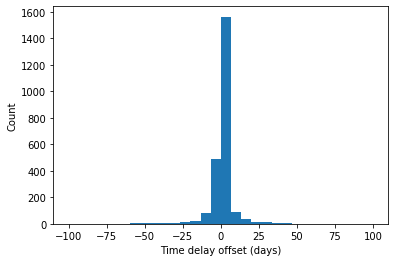

In [21]:
vals = good_truth['t_delay_offset'].values
plt.xlabel('Time delay offset (days)')
plt.ylabel('Count')
_ = plt.hist(vals[np.isfinite(vals)], bins=30, range=[-100, 100])

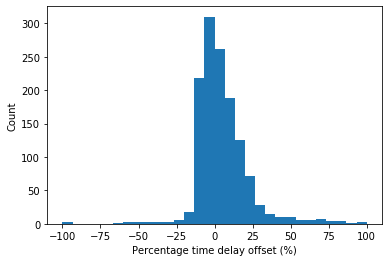

In [29]:
vals = good_truth['t_delay_offset_frac'].values*100
plt.xlabel('Percentage time delay offset (%)')
plt.ylabel('Count')
_ = plt.hist(vals[np.isfinite(vals)], bins=30, range=[-100, 100])

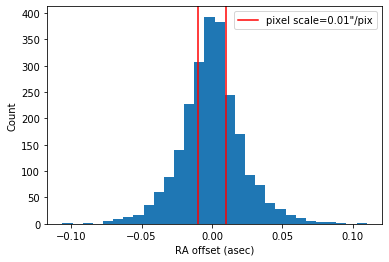

In [37]:
vals = good_truth['ra_offset'].values
plt.xlabel('RA offset (asec)')
plt.ylabel('Count')
plt.axvline(0.01, color='r', label='pixel scale=0.01"/pix')
plt.axvline(-0.01, color='r')
_ = plt.hist(vals[np.isfinite(vals)], bins=30)
plt.legend()

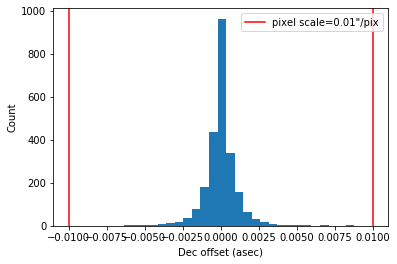

In [38]:
vals = good_truth['dec_offset'].values
plt.xlabel('Dec offset (asec)')
plt.ylabel('Count')
plt.axvline(0.01, color='r', label='pixel scale=0.01"/pix')
plt.axvline(-0.01, color='r')
_ = plt.hist(vals[np.isfinite(vals)], bins=30)
plt.legend()